In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = '/Users/marina/Documents/PhD/research/astro_research/code/dist_code/data/'
with open(DATA_DIR + 'lsst-sims.pk', 'rb') as f:
    lc_prop = pickle.load(f)

In [ ]:
    # keys are:
    # obj_id:                         light curve id
    # true_z, photo_z:                transient redshift and host photo-z

    # These columns are calculated for each band (* = u, g, r, i, z, y)

    # *_first_mjd:                    epoch of initial detection ('first epoch')
    # *_first_snr:                    first-epoch SNR
    # *_min_snr, *_max_snr:           minimal and maximal SNR of the light curve
    # *_first_mag, *_first_mag_err:   first-epoch magnitude and error
    # *_min_mag, *_min_mag_err:       faintest magnitude and error
    # *_max_mag, *_max_mag_err:       peak or brighest magnitude and error
    # *_first_flux, *_first_flux_err: first-epoch physical flux and error
    # *_min_flux, *_min_flux_err:     minimal flux (matching faintest magnitude)
    # *_max_flux, *_max_flux_err:     maximal flux (matching peak magnitude)

In [5]:
%matplotlib inline

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarni

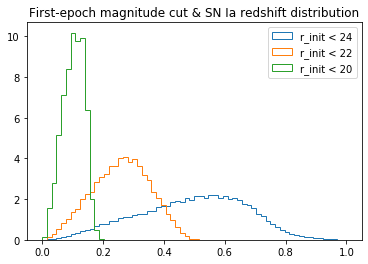

In [2]:
lc_prop_Ia = lc_prop['Ia']

rmag_24 = lc_prop_Ia['r_first_mag'] < 24.0
rmag_22 = lc_prop_Ia['r_first_mag'] < 22.0
rmag_20 = lc_prop_Ia['r_first_mag'] < 20.0

zred_24 = lc_prop_Ia['true_z'][rmag_24]
zred_22 = lc_prop_Ia['true_z'][rmag_22]
zred_20 = lc_prop_Ia['true_z'][rmag_20]

# plot distribution.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(zred_24, range=(0., 1.), bins=64,
        histtype='step', normed=True, label='r_init < 24')
ax.hist(zred_22, range=(0., 1.), bins=64,
        histtype='step', normed=True, label='r_init < 22')
ax.hist(zred_20, range=(0., 1.), bins=64,
        histtype='step', normed=True, label='r_init < 20')
plt.title('First-epoch magnitude cut & SN Ia redshift distribution')
plt.legend()
plt.savefig('3.pdf')
plt.show()


In [10]:
# Overlay plot with redshift distribution of database 
def get_attributes(data_file, rowmask_file):
    """
    Uses redshift and labels & returns redshifts, valid redshifts, and idxf
    idxf is  map from each class name to  a list that is the same length as the number of samples in the dataset. for each one, it is True or False, based on whether that sample contains that label.
    """
    data = np.load(DATA_DIR + data_file, allow_pickle=True)
    rowmask = np.load(DATA_DIR + rowmask_file, allow_pickle=True)
    z = data['redshift']
    valid_z = np.isfinite(z)
    idxf = {r: rowmask[r] == 1 for r in list(rowmask.dtype.names)}
    return z, valid_z, idxf
allmags_zred, allmags_valid_z, allmags_idxf = get_attributes(
        data_file='allmags_data.npy',
        rowmask_file='allmags_rowmask.npy')

In [71]:

import pandas as pd

def get_data(name):
    """
    Pull down project data, one of two types:
    all-features-dataset: 'all_features'
    g_W2-dataset: 'g_W2'
    """
    X = pd.read_csv(DATA_DIR + name + '_X.csv')
    X.drop(['Unnamed: 0'], axis=1, inplace=True)
    y = pd.read_csv(DATA_DIR + name + '_y.csv')
    y.drop(['Unnamed: 0'], axis=1, inplace=True)
    df = pd.concat([X, y], axis=1)
    return df
    


In [73]:

# Get samples from this class with this feature range


TARGET_LABEL = 'transient_type'
def convert_str_to_list(input_string):
    """
    Convert string to list
    """
    l = input_string.split(",")
    return [item.strip(' ') for item in l]


## TODO: update this to return redshifts for this range!!!!!
def filter_class_feature_range(class_name, feature_name, min_feature, max_feature, data):
    """
    Get redshift values for data filtered on this range:
    Filter data to those with class value and feature in range. 
    :param class_name: class name to filter on
    :param feature_name: Name of feature to filter on
    :param min_feature: Minimum feature value to keep
    :param max_feature: Maximum feature value to keep
    :param data: Pandas DataFrame from model 
    """

    keep_indices = []
    min_feature = feature_range[0]
    max_feature = feature_range[1]
    for index, row in df.iterrows():
        labels = convert_str_to_list(row[TARGET_LABEL])
        in_range = row[feature_name] >= min_feature and row[feature_name] <= max_feature
        if class_name in labels and in_range:
            keep_indices.append(index)

    filt_df = df.loc[keep_indices, :].reset_index(drop=True)
    
    return filt_df['redshift'].values



In [55]:
def filter_lsst_data(class_name, feature_name, min_feature, max_feature, data):
    """
    Get redshift values for data filtered on this range: label class_name
    whose  feature values are in the range [min_feature,max_feature ] 
    :param data: loaded pickle of lsst-sims.pk
    """
    class_data = data[class_name]
    
    feature_vals = class_data[feature_name]
    indices = np.where((feature_vals>=min_feature) & (feature_vals<=max_feature))[0]
    
    class_data_Z = class_data['true_z']
    class_data_filt = np.take(class_data_Z, indices)
    
    return class_data_filt
    
## TODO: update this to return redshifts for this range!!!!!   


In [ ]:
df = get_data(name='all_features')

In [76]:
list(df)

['W3_mag',
 'y_mag',
 'g_mag',
 'z_mag',
 'r_mag',
 'u_mag',
 'NUV_mag',
 'W2_mag',
 'FUV_mag',
 'i_mag',
 'H_mag',
 'K_mag',
 'W4_mag',
 'W1_mag',
 'J_mag',
 'transient_type']

In [74]:

## TODO: update this to return redshifts for this range!!!!!
# need to compare redshifts
min_range = 22
max_range = 24
class_name =  "Ia"

thex_data_filt = filter_class_feature_range(class_name=class_name,
                                    feature_name = 'r_mag',
                                    min_feature=min_range, 
                                    max_feature=max_range,
                                    data = df      )

lsst_data_filt = filter_lsst_data(class_name=class_name, 
                 feature_name='r_first_mag', 
                 min_feature=min_range, 
                 max_feature=max_range, 
                 data=lc_prop)

KeyError: 'redshift'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


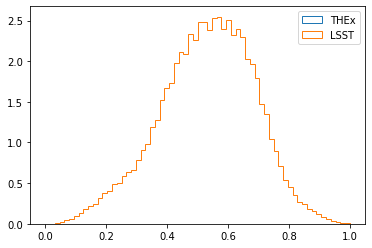

In [68]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(thex_data_filt, 
        range=(0., 1.), 
        bins=64,
        histtype='step', 
        normed=True, 
        label='THEx')
ax.hist(lsst_data_filt, 
        range=(0., 1.), 
        bins=64,
        histtype='step', 
        normed=True, 
        label='LSST')
plt.legend()
plt.show()

In [ ]:

# # -------------------------------------------------------------------------
# # Example: For SNe Ia, first-epoch magnitude vs. redshift.
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.hist2d(lc_prop['Ia']['r_first_mag'], lc_prop['Ia']['true_z'],
#           range=((18., 26.5), (0., 1.25)), bins=64, cmap='Blues')
# plt.title('First-epoch r-band magnitude vs. redshift (SNe Ia)')
# plt.xlabel('r_first'), plt.ylabel('redshift')
# plt.savefig('4.pdf')
# plt.show()